In [69]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy.special import erf
from numpy import sqrt, exp, log, pi

In [64]:
import PDIC_pricing 
import importlib 
importlib.reload(PDIC_pricing)

<module 'PDIC_pricing' from 'c:\\Users\\Ben\\Projet-Monte-Carlo\\PDIC_pricing.py'>

In [59]:
def visualize_pdic_paths(S0, K, L, r, q, sigma, T, D, num_steps, num_paths=10, seed=42):
    np.random.seed(seed)
    dt = T / num_steps
    min_consec_steps = int(D / dt)
    
    # Simulate paths
    drift = (r - q - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    Z = np.random.randn(num_paths, num_steps)
    log_returns = drift + diffusion * Z
    log_paths = np.cumsum(log_returns, axis=1)
    log_paths = np.hstack([np.zeros((num_paths, 1)), log_paths])
    S_paths = S0 * np.exp(log_paths)

    # Plot setup
    plt.figure(figsize=(12, 6))
    time_grid = np.linspace(0, T, num_steps + 1)
    
    for i, path in enumerate(S_paths):
        below_barrier = path < L
        consec = 0
        activated = False
        for flag in below_barrier:
            if flag:
                consec += 1
                if consec >= min_consec_steps:
                    activated = True
                    break
            else:
                consec = 0

        label = f"Path {i+1} {'(Activated)' if activated else '(Inactive)'}"
        color = "green" if activated else "red"
        plt.plot(time_grid, path, color=color, alpha=0.7, label=label)

    # Draw barrier line
    plt.axhline(y=L, color='blue', linestyle='--', linewidth=2, label=f"Barrier L={L}")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.title("Monte Carlo Paths for PDIC — Activation Visualization")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

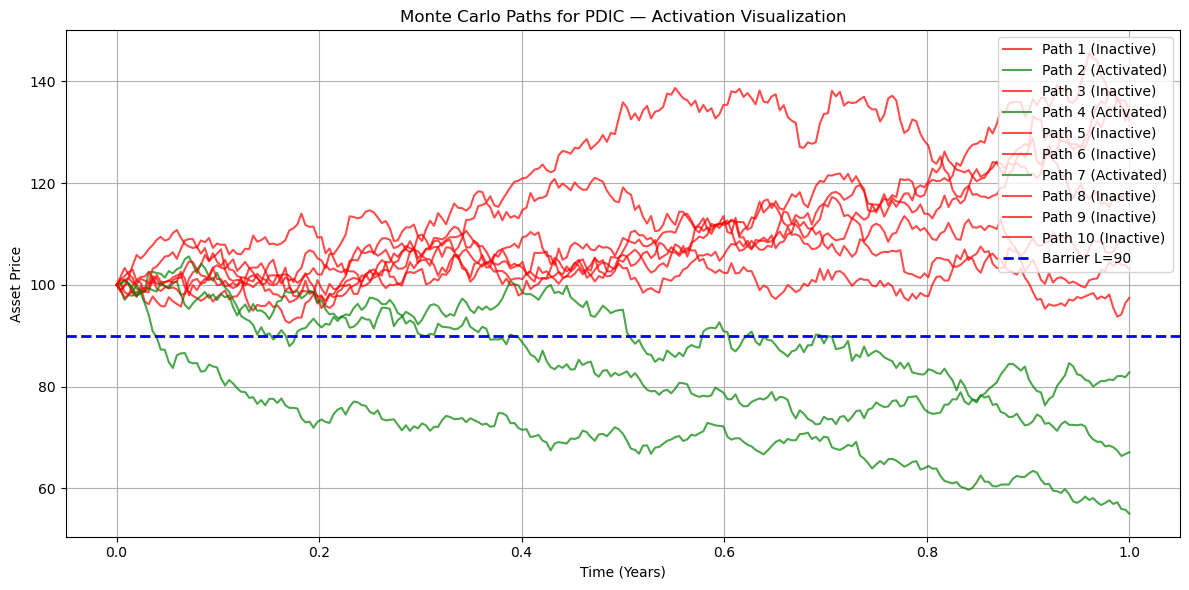

In [60]:
visualize_pdic_paths(
    S0=100, K=100, L=90,
    r=0.025, q=0, sigma=0.2,
    T=1, D=20 / 252,
    num_steps=252,
    num_paths=10,
    seed=123
)

## 1. PDIC 

### Evaluation de l'option PDIC par des chemins Monte Carlo

In [67]:
from PDIC_pricing import price_parisian_down_in_call_mc,simulate_black_scholes_paths,price_parisian_down_in_call_mc_with_ci

# Parameters
# Parameters
S0 = 100
K = 105  # Must be > L for this formula
L = 90
r = 0.025
delta = 0
sigma = 0.2
D = 20 / 252
T = 1
q = 0
num_steps = 252
num_simulations = 100_000

# Simulate paths
S_paths = simulate_black_scholes_paths(S0, r, q, sigma, T, num_steps, num_simulations, seed=42)

# Price PDIC
pdic_price, pdic_ci = price_parisian_down_in_call_mc_with_ci(S_paths, K, L, r, T, D, num_steps)
pdic_str = f"PDIC MC Price : {pdic_price:.4f} (95% CI: [{pdic_ci[0]:.4f}, {pdic_ci[1]:.4f}])"
pdic_str

'PDIC MC Price : 0.2271 (95% CI: [0.2153, 0.2388])'

### Evaluation de l'option PDIC en utilisant le transformée de laplace (le cas K>L et b<=0)

In [17]:
import PDIC_pricing 
import importlib 
importlib.reload(PDIC_pricing)

<module 'PDIC_pricing' from 'c:\\Users\\Ben\\Projet-Monte-Carlo\\PDIC_pricing.py'>

In [16]:
from PDIC_pricing import N_complex,psi,laplace_transform_pdic_star_K_gt_L,inverse_laplace_transform

In [18]:
# Compute inverse Laplace
pdic_star_price = inverse_laplace_transform(
    laplace_transform_pdic_star_K_gt_L, T, S0, K, L, r, delta, sigma, D, alpha=10, N=15
)

# Convert back from starred price to actual price:
m = (r - delta - 0.5 * sigma ** 2) / sigma
pdic_price = exp(-(r + 0.5 * m ** 2) * T) * pdic_star_price
pdic_price

0.18573605320009492

#### Comparaison des méthodes pour des valeurs du K et D

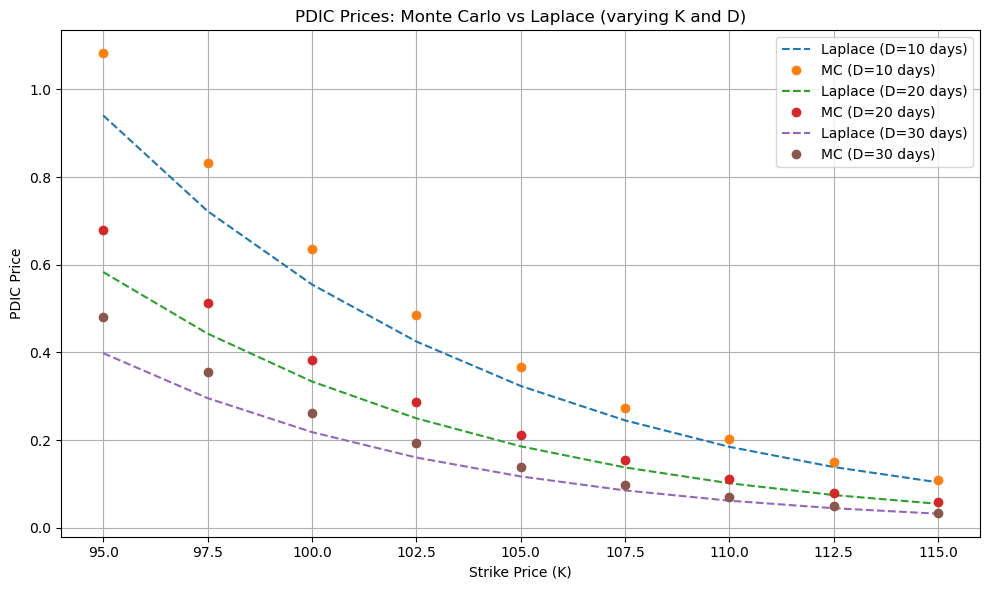

In [19]:
##Comparaision :
strike_values = np.linspace(95, 115, 9)
delays = [10 / 252, 20 / 252, 30 / 252]

# Reduce number of simulations to avoid memory error
num_simulations = 20_000  # Reduced from 100,000

# Re-simulate
S_paths = simulate_black_scholes_paths(S0, r, delta, sigma, T, num_steps, num_simulations, seed=42)

# Store results for plotting
results = {delay: {"strike": [], "laplace": [], "montecarlo": []} for delay in delays}

for D in delays:
    for K_val in strike_values:
        # Laplace price
        laplace_price = inverse_laplace_transform(
            laplace_transform_pdic_star_K_gt_L, T, S0, K_val, L, r, delta, sigma, D, alpha=10, N=15
        )
        m = (r - delta - 0.5 * sigma ** 2) / sigma
        laplace_price = exp(-(r + 0.5 * m ** 2) * T) * laplace_price

        # Monte Carlo price
        mc_price = price_parisian_down_in_call_mc(S_paths, K_val, L, r, T, D, num_steps)

        # Store
        results[D]["strike"].append(K_val)
        results[D]["laplace"].append(laplace_price)
        results[D]["montecarlo"].append(mc_price)

# Plotting
plt.figure(figsize=(10, 6))
for D in delays:
    plt.plot(results[D]["strike"], results[D]["laplace"], label=f'Laplace (D={int(D*252)} days)', linestyle='--')
    plt.plot(results[D]["strike"], results[D]["montecarlo"], label=f'MC (D={int(D*252)} days)', marker='o', linestyle='')

plt.xlabel("Strike Price (K)")
plt.ylabel("PDIC Price")
plt.title("PDIC Prices: Monte Carlo vs Laplace (varying K and D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


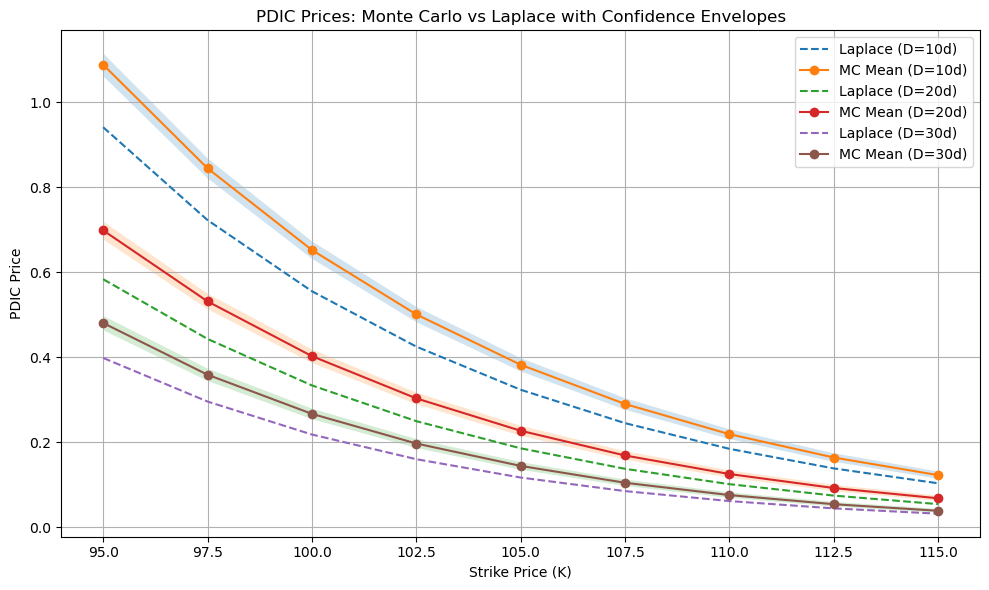

In [68]:

strike_values = np.linspace(95, 115, 9)
delays = [10 / 252, 20 / 252, 30 / 252]
S_paths = simulate_black_scholes_paths(S0, r, q, sigma, T, num_steps, num_simulations, seed=42)

# ----------------------------
# Compute prices
# ----------------------------
results = {D: {"strike": [], "laplace": [], "mc_mean": [], "mc_lower": [], "mc_upper": []} for D in delays}

for D in delays:
    for K in strike_values:
        laplace_star = inverse_laplace_transform(
            laplace_transform_pdic_star_K_gt_L, T, S0, K, L, r, q, sigma, D, alpha=10, N=15
        )
        m = (r - q - 0.5 * sigma ** 2) / sigma
        laplace_price = exp(-(r + 0.5 * m ** 2) * T) * laplace_star

        mc_price, (ci_low, ci_high) = price_parisian_down_in_call_mc_with_ci(S_paths, K, L, r, T, D, num_steps)

        results[D]["strike"].append(K)
        results[D]["laplace"].append(laplace_price)
        results[D]["mc_mean"].append(mc_price)
        results[D]["mc_lower"].append(ci_low)
        results[D]["mc_upper"].append(ci_high)

# ----------------------------
# Plot with confidence envelopes
# ----------------------------
plt.figure(figsize=(10, 6))
for D in delays:
    x = np.array(results[D]["strike"])
    laplace = results[D]["laplace"]
    mc = np.array(results[D]["mc_mean"])
    ci_low = np.array(results[D]["mc_lower"])
    ci_high = np.array(results[D]["mc_upper"])

    plt.plot(x, laplace, linestyle='--', label=f'Laplace (D={int(D*252)}d)')
    plt.plot(x, mc, marker='o', label=f'MC Mean (D={int(D*252)}d)')
    plt.fill_between(x, ci_low, ci_high, alpha=0.2)

plt.xlabel("Strike Price (K)")
plt.ylabel("PDIC Price")
plt.title("PDIC Prices: Monte Carlo vs Laplace with Confidence Envelopes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

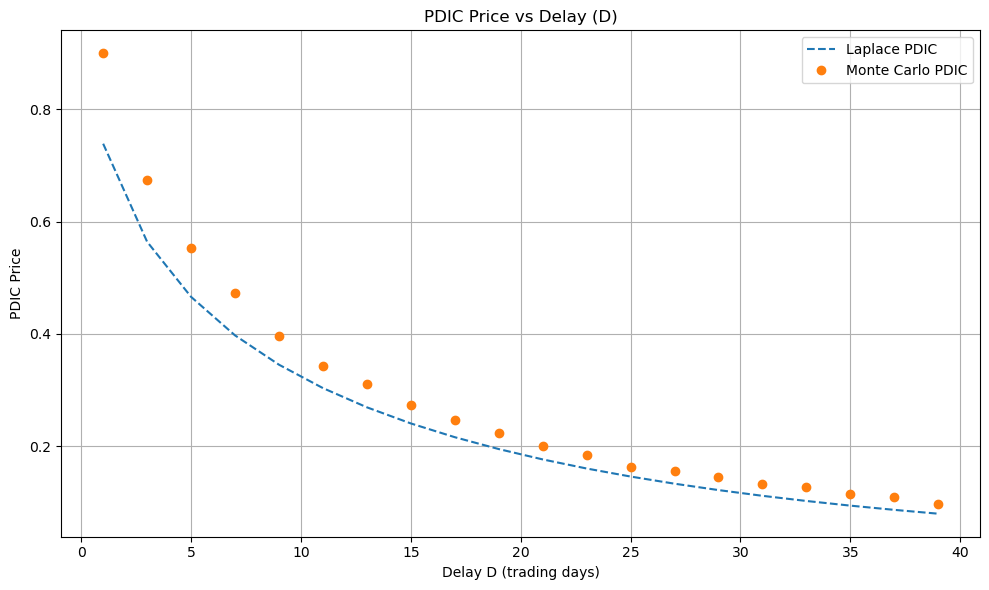

In [20]:

# Delay values (x-axis): from 1 to 40 trading days
delay_days = np.arange(1, 41, 2)
delay_years = delay_days / 252

# Simulate paths for MC
S_paths = simulate_black_scholes_paths(S0, r, delta, sigma, T, num_steps, num_simulations, seed=42)


# Compute prices for each delay
laplace_pdic = []
mc_pdic = []

for D in delay_years:
    # Laplace inversion for PDIC
    pdic_star_price = inverse_laplace_transform(
        laplace_transform_pdic_star_K_gt_L, T, S0, K, L, r, delta, sigma, D, alpha=10, N=15
    )
    m = (r - delta - 0.5 * sigma ** 2) / sigma
    pdic_price_laplace = exp(-(r + 0.5 * m ** 2) * T) * pdic_star_price
    laplace_pdic.append(pdic_price_laplace)

    # Monte Carlo
    pdic_price_mc = price_parisian_down_in_call_mc(S_paths, K, L, r, T, D, num_steps)
    mc_pdic.append(pdic_price_mc)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(delay_days, laplace_pdic, label="Laplace PDIC", linestyle='--')
plt.plot(delay_days, mc_pdic, label="Monte Carlo PDIC", marker='o', linestyle='')

plt.xlabel("Delay D (trading days)")
plt.ylabel("PDIC Price")
plt.title("PDIC Price vs Delay (D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

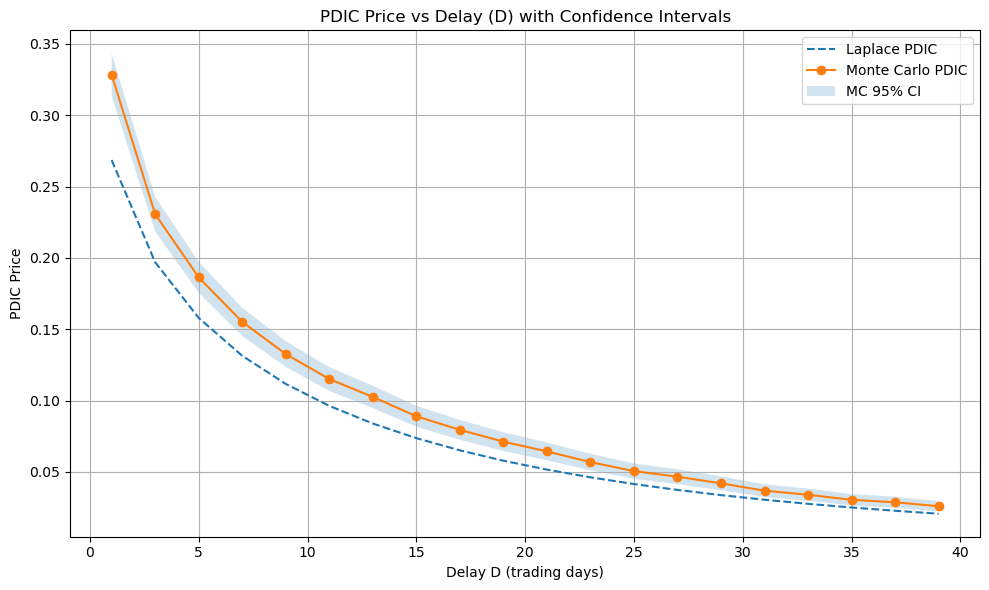

In [70]:
# Extend the code to include confidence intervals in the plot

# Delay values (x-axis): from 1 to 40 trading days
delay_days = np.arange(1, 41, 2)
delay_years = delay_days / 252

# Simulate paths for MC
S_paths = simulate_black_scholes_paths(S0, r, q, sigma, T, num_steps, num_simulations, seed=42)

# Store results
laplace_pdic = []
mc_pdic = []
mc_ci_lower = []
mc_ci_upper = []

for D in delay_years:
    # Laplace inversion for PDIC
    pdic_star_price = inverse_laplace_transform(
        laplace_transform_pdic_star_K_gt_L, T, S0, K, L, r, q, sigma, D, alpha=10, N=15
    )
    m = (r - q - 0.5 * sigma ** 2) / sigma
    pdic_price_laplace = exp(-(r + 0.5 * m ** 2) * T) * pdic_star_price
    laplace_pdic.append(pdic_price_laplace)

    # Monte Carlo with confidence intervals
    pdic_price_mc, (ci_low, ci_high) = price_parisian_down_in_call_mc_with_ci(S_paths, K, L, r, T, D, num_steps)
    mc_pdic.append(pdic_price_mc)
    mc_ci_lower.append(ci_low)
    mc_ci_upper.append(ci_high)

# Convert to numpy arrays
mc_pdic = np.array(mc_pdic)
mc_ci_lower = np.array(mc_ci_lower)
mc_ci_upper = np.array(mc_ci_upper)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(delay_days, laplace_pdic, label="Laplace PDIC", linestyle='--')
plt.plot(delay_days, mc_pdic, label="Monte Carlo PDIC", marker='o')

# Add confidence envelope
plt.fill_between(delay_days, mc_ci_lower, mc_ci_upper, alpha=0.2, label="MC 95% CI")

plt.xlabel("Delay D (trading days)")
plt.ylabel("PDIC Price")
plt.title("PDIC Price vs Delay (D) with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. PUIC 

### Evaluation de l'option PUIC par des chemins Monte Carlo  cas (b>=0 et K<=L)

In [23]:
from PUIC_pricing import price_parisian_up_in_call_mc

In [49]:
# Example Parameters

num_steps = 252
num_simulations = 100_000

# Example test
S0 = 100
K = 95
L = 110
r = 0.025
delta = 0
sigma = 0.2
D = 20 / 252
lam = 2.0  # Use small λ for stable test

# Simulate paths
S_paths = simulate_black_scholes_paths(S0, r, q, sigma, T, num_steps, num_simulations, seed=123)

In [51]:
# Price PUIC
puic_price = price_parisian_up_in_call_mc(S_paths, K, L, r, T, D, num_steps)
print(f"PUIC Monte Carlo Price: {puic_price:.4f}")

PUIC Monte Carlo Price: 10.2334


### Evaluation de l'option PUIC en utilisant le transformée de laplace (le cas K>L et b<=0)

In [52]:
import PUIC_pricing 
import importlib 
importlib.reload(PUIC_pricing)

<module 'PUIC_pricing' from 'c:\\Users\\Ben\\Projet-Monte-Carlo\\PUIC_pricing.py'>

In [53]:
from PUIC_pricing import laplace_transform_puic_star_K_leq_L,inverse_laplace_transform_puic_K_leq_H,N_complex,psi

In [54]:
# Compute the Laplace transform value for PUIC★ using the new expression
puic_star_val_new = laplace_transform_puic_star_K_leq_L(S0, K, L, r, delta, sigma, D, lam)
puic_star_val_new


# Compute with adjusted alpha
puic_star_price_fixed = inverse_laplace_transform_puic_K_leq_H(T, S0, K, H, r, delta, sigma, D, alpha=2.0, N=15)

# Convert from starred to actual price
puic_price_fixed = exp(-(r + 0.5 * m ** 2) * T) * puic_star_price_fixed

print(f"PUIC Inverse laplace Price: {puic_price_fixed:.4f}")

PUIC Inverse laplace Price: 10.3558


#### Comparaison des méthodes pour des valeurs du K et D

In [55]:
# Example test
S0 = 100
K = 95
L = 110
r = 0.025
delta = 0
sigma = 0.2
D = 20 / 252
lam = 2.0  # Use small λ for stable test

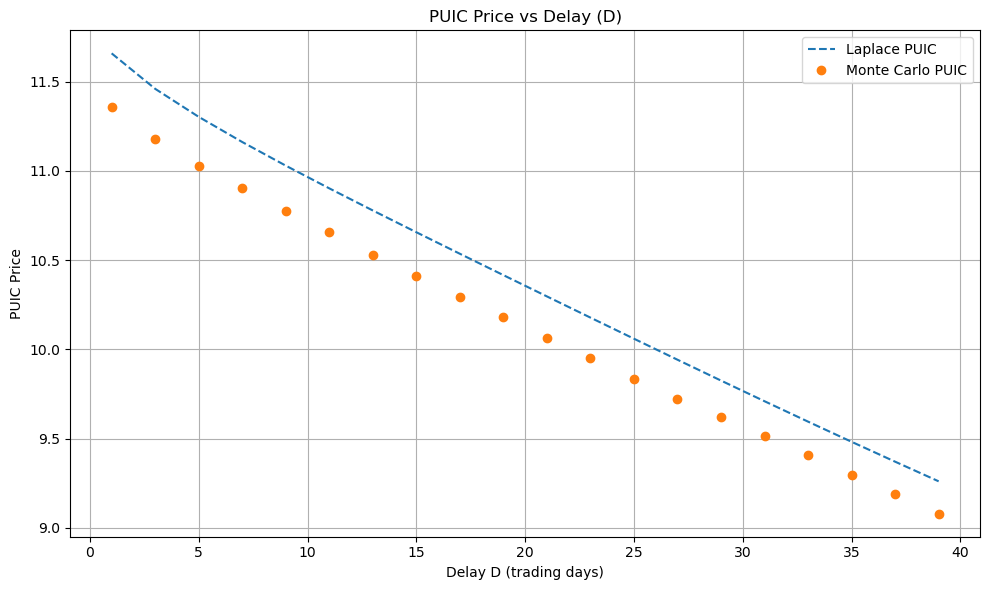

In [56]:
# Generate a plot comparing Monte Carlo and Laplace for PUIC (using new formula)

# Delay range
delay_days = np.arange(1, 41, 2)
delay_years = delay_days / 252

# Reuse S0, K, L, r, delta, sigma, T, num_steps, num_simulations
# Simulate paths for Monte Carlo
S_paths = simulate_black_scholes_paths(S0, r, delta, sigma, T, num_steps, num_simulations, seed=42)

# Containers for results
puic_laplace_prices = []
puic_mc_prices = []


# Loop over delays
for D in delay_years:
    # Laplace PUIC price
    puic_star = inverse_laplace_transform_puic_K_leq_H(T, S0, K, L, r, delta, sigma, D, alpha=2.0, N=15)
    m = (r - delta - 0.5 * sigma ** 2) / sigma
    puic_price_laplace = exp(-(r + 0.5 * m ** 2) * T) * puic_star
    puic_laplace_prices.append(puic_price_laplace)

    # Monte Carlo PUIC price
    puic_price_mc = price_parisian_up_in_call_mc(S_paths, K, L, r, T, D, num_steps)
    puic_mc_prices.append(puic_price_mc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(delay_days, puic_laplace_prices, label="Laplace PUIC", linestyle='--')
plt.plot(delay_days, puic_mc_prices, label="Monte Carlo PUIC", marker='o', linestyle='')

plt.xlabel("Delay D (trading days)")
plt.ylabel("PUIC Price")
plt.title("PUIC Price vs Delay (D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


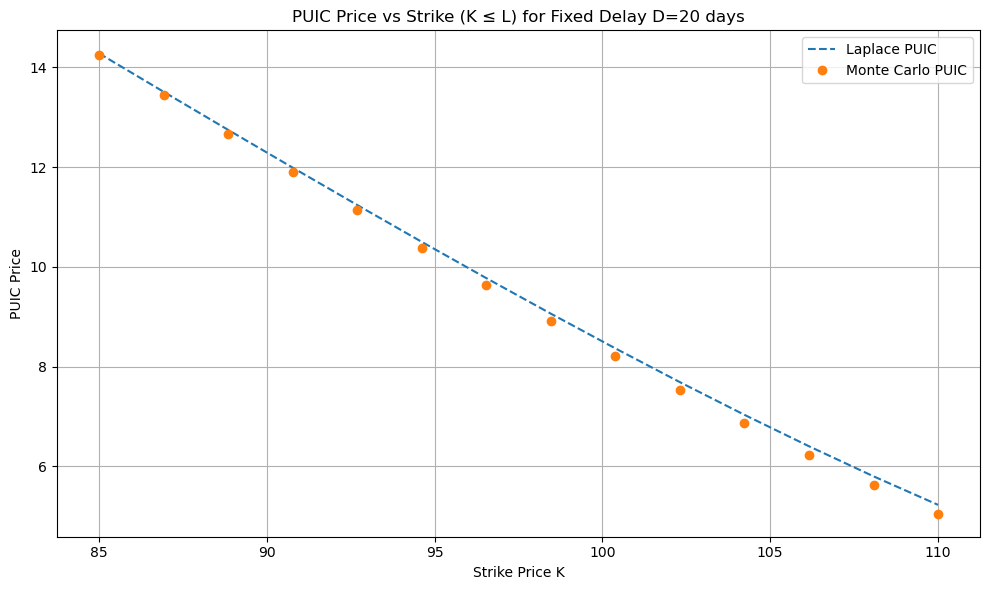

In [57]:
# Define a range of strike prices K <= L for comparison
strike_values = np.linspace(85, 110, 14)  # Ensure K <= L = 110

# Fixed delay
D = 20 / 252  # 20 trading days

# Store results
puic_laplace_vs_strike = []
puic_mc_vs_strike = []

# Reuse simulation
S_paths = simulate_black_scholes_paths(S0, r, delta, sigma, T, num_steps, num_simulations, seed=123)

# Loop over strike prices
for K_val in strike_values:
    # Laplace method
    puic_star = inverse_laplace_transform_puic_K_leq_H(T, S0, K_val, L, r, delta, sigma, D, alpha=2.0, N=15)
    m = (r - delta - 0.5 * sigma ** 2) / sigma
    puic_price_laplace = exp(-(r + 0.5 * m ** 2) * T) * puic_star
    puic_laplace_vs_strike.append(puic_price_laplace)

    # Monte Carlo
    puic_price_mc = price_parisian_up_in_call_mc(S_paths, K_val, L, r, T, D, num_steps)
    puic_mc_vs_strike.append(puic_price_mc)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(strike_values, puic_laplace_vs_strike, label="Laplace PUIC", linestyle='--')
plt.plot(strike_values, puic_mc_vs_strike, label="Monte Carlo PUIC", marker='o', linestyle='')

plt.xlabel("Strike Price K")
plt.ylabel("PUIC Price")
plt.title("PUIC Price vs Strike (K ≤ L) for Fixed Delay D=20 days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()